In [292]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import json
import codecs
import numpy as np
import progressbar
import sys
import torchvision.transforms as transforms
import utils
import argparse
import ctypes as ct
import json
from numpy.linalg import inv
import pickle
from datasets import Places365Dataset, ViewDataSet3D

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print('test')
parser = argparse.ArgumentParser()
parser.add_argument('--debug'  , action='store_true', help='debug mode')
parser.add_argument('--dataroot', required=True, help='path to dataset')
opt = parser.parse_args(['--dataroot', '/home/fei/Downloads/highres_tiny/'])
tf = transforms.Compose([
    transforms.Scale(1024, 1024 * 2),
    transforms.ToTensor(),
])
    
mist_tf = transforms.Compose([
    transforms.ToTensor(),
])

d = ViewDataSet3D(root=opt.dataroot, debug=opt.debug, transform=tf, mist_transform=mist_tf, seqlen = 2, off_3d = False, off_pc_render = True)
print(len(d))
means = []


test
Processing the data:
highres_tiny_fofn1.pkl
Total 9 scenes 8 train 1 test
423


In [3]:
print(len(d))

423


In [230]:
class Depth3DGridGen(nn.Module):
    def __init__(self, height, width):
        super(Depth3DGridGen, self).__init__()
        self.height, self.width = height, width
        self.grid = np.zeros( [self.height, self.width, 3], dtype=np.float32)
        self.grid[:,:,0] = np.expand_dims(np.repeat(np.expand_dims(np.arange(-1, 1, 2.0/self.height), 0), repeats = self.width, axis = 0).T, 0)
        self.grid[:,:,1] = np.expand_dims(np.repeat(np.expand_dims(np.arange(-1, 1, 2.0/self.width), 0), repeats = self.height, axis = 0), 0)
        self.grid[:,:,2] = np.ones([self.height, width])
        self.grid = torch.from_numpy(self.grid.astype(np.float32))

        self.theta = self.grid[:,:,0] * np.pi/2 + np.pi/2
        self.phi = self.grid[:,:,1] * np.pi

        self.x = torch.sin(self.theta) * torch.cos(self.phi)
        self.y = torch.sin(self.theta) * torch.sin(self.phi)
        self.z = torch.cos(self.theta)

        self.grid3d = torch.from_numpy(np.zeros( [self.height, self.width, 4], dtype=np.float32))

        self.grid3d[:,:,0] = self.x
        self.grid3d[:,:,1] = self.y
        self.grid3d[:,:,2] = self.z
        self.grid3d[:,:,3] = self.grid[:,:,2]


    def forward(self, depth, transformation):
        
        batchsize = torch.Size([depth.size(0)])
        bs = depth.size(0)
        
        self.batchgrid3d = torch.zeros(batchsize + self.grid3d.size())

        for i in range(depth.size(0)):
            self.batchgrid3d[i] = self.grid3d

        self.batchgrid3d = Variable(self.batchgrid3d)
        self.batchgrid = torch.zeros(batchsize + self.grid.size())

        for i in range(depth.size(0)):
            self.batchgrid[i] = self.grid

        self.batchgrid = Variable(self.batchgrid)

        if depth.is_cuda:
             self.batchgrid3d =  self.batchgrid3d.cuda()
        
        x = self.batchgrid3d[:,:,:,0:1] * depth
        y = self.batchgrid3d[:,:,:,1:2] * depth
        z = self.batchgrid3d[:,:,:,2:3] * depth
                
        points = torch.cat([x,y,z,self.batchgrid3d[:,:,:,3:]], -1)
        points = points.view(bs, 1024 * 2048, 4)
        points = torch.bmm(points, pose)
        points = points.view(bs, 1024, 2048, 4)
        
        x = points[:,:,:,0:1]
        y = points[:,:,:,1:2]
        z = points[:,:,:,2:3]
        
        r = torch.sqrt(x**2 + y**2 + z**2)
        
        print(torch.mean(r))
        
        theta = torch.acos(z/r)/(np.pi/2)  - 1
        phi = torch.atan2(y,x)
        phi = phi/np.pi

        output = torch.cat([phi,theta], 3)
        
        return output

In [231]:
gridgen = Depth3DGridGen(1024, 2048)

In [467]:
data = d[420]

In [468]:
source = Variable(data[0][0]).cuda().unsqueeze(0)
target = Variable(data[1]).cuda().unsqueeze(0)
depth = Variable(data[2][0]).cuda().transpose(1,0).transpose(2,1).unsqueeze(0).float() * 255 * 128
pose = Variable(data[-1][0]).cuda().unsqueeze(0).float().transpose(2,1)

In [469]:
torch.mean(depth)

Variable containing:
 2.5321
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [470]:
grid = gridgen(depth, pose)

Variable containing:
(   0   ,.,.) = 
   -0.0000    0.0000    1.2402    1.0000
   -0.0000   -0.0000    1.2402    1.0000
   -0.0000   -0.0000    1.2402    1.0000
                   ⋮                    
   -0.0043    0.0000   -1.4160    1.0000
   -0.0043    0.0000   -1.4160    1.0000
   -0.0043    0.0000   -1.4160    1.0000
[torch.cuda.FloatTensor of size 1x2097152x4 (GPU 0)]

Variable containing:
 2.9598
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [471]:
dll2=np.ctypeslib.load_library('occinf','.')
depth_np = (depth.cpu().data[0].numpy()[:,:,0]/128.0).astype(np.float32)
pose_after_np = pose.transpose(2,1).cpu().data[0].numpy().astype(np.float32)
occ_np = np.zeros((1024,1024 * 2)).astype(np.bool)
target_depth_np = np.zeros((1024,1024 * 2)).astype(np.uint32)
target_depth_np[:] = 65535
dll2.occinf(ct.c_int(1024),
    ct.c_int(2048),
    depth_np.ctypes.data_as(ct.c_void_p),
    pose_after_np.ctypes.data_as(ct.c_void_p),
    occ_np.ctypes.data_as(ct.c_void_p),
    target_depth_np.ctypes.data_as(ct.c_void_p)
)

mask = torch.from_numpy(occ_np.astype(np.float32))
mask_v = Variable(mask.view(1,1,1024,2048).repeat(1,3,1,1)).cuda()


In [472]:
sample = F.grid_sample(target, grid)
mask2 = (F.grid_sample(mask_v, grid) > 0).float()

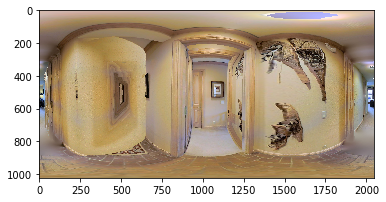

In [473]:
plt.imshow(sample[0].data.cpu().numpy().transpose(1,2,0))
Image.fromarray((sample[0].data.cpu().numpy().transpose(1,2,0) * 255).astype(np.uint8)).save('sampled.png')

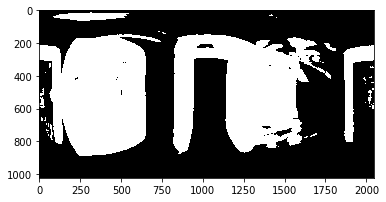

In [474]:
plt.imshow(mask2[0].data.cpu().numpy().transpose(1,2,0))

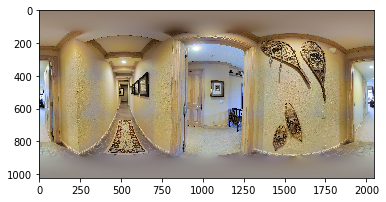

In [475]:
plt.imshow(source[0].data.cpu().numpy().transpose(1,2,0))

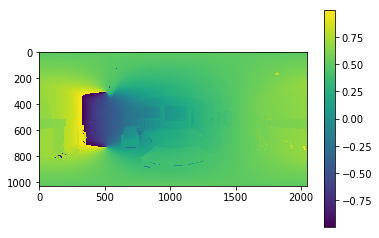

In [460]:
plt.imshow(grid[0].cpu().data.numpy()[:,:,0])
plt.colorbar()

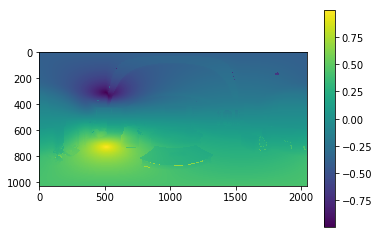

In [461]:
plt.imshow(grid[0].cpu().data.numpy()[:,:,1])
plt.colorbar()

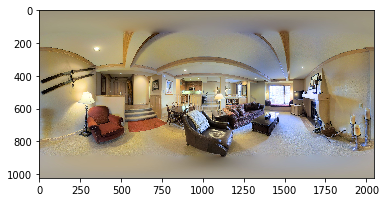

In [462]:
plt.imshow(target[0].data.cpu().numpy().transpose(1,2,0))